<a href="https://colab.research.google.com/github/leahandofir/earthformer-inference-experiments/blob/main/google_colab_experiments/fss_debug.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [76]:
#
#
# ------------- FIRST ------------------------
#
#
#

In [112]:
import torch
import torch.nn.functional as F


class FSSLoss(torch.nn.Module):
    # TODO: write what every input is suppose to be
    def __init__(self,
                 threshold: int, # TODO: maybe we can try discretization of more then 1 value?
                 scale: int,
                 hwc: tuple,
                 seq_len: int,
                 minimize: bool = True,
                 smooth_factor: int = 20,
                 pixel_scale: bool = True,
                 strategy: str = "tanh",
                 device: torch.device = torch.device('cuda')):
        super(FSSLoss, self).__init__()
        self.threshold = threshold
        self.scale = scale
        self.hwc = hwc
        self.seq_len = seq_len
        self.minimize = minimize
        self.smooth_factor = smooth_factor
        self.pixel_scale = 255 if pixel_scale else 1
        self.strategy = strategy
        self.neighborhood_filter_dim = (self.seq_len * self.hwc[-1], self.seq_len * self.hwc[-1], self.scale, self.scale)
        self.neighborhood_filter_mat = torch.full(self.neighborhood_filter_dim, 1 / self.scale ** 2, device=device)
        # print(self.neighborhood_filter_mat)
        # print(self.neighborhood_filter_mat.shape)

    # warning - heavily assumes layout NTWHC!

    def _preprocess(self, batch):
        # the input is of shape NTHWC
        # rescale pixels back to 0-255
        batch = batch * self.pixel_scale
        # print(batch.shape)

        # flatten sequence to 3-dim by increasing number of channels, the resulted shape is NCWH
        # (used negative indices in order to handle both batch-input and single-input)
        batch = torch.flatten(batch.moveaxis(-1, -3), start_dim=-4, end_dim=-3)

        # 'binarize' data
        if self.strategy == "hardtanh":
            # hardtanh is applied element wise. for every coordinate x:
            #   if x > max_val -> max_val
            #   if x < min_val -> min_val
            #   else x
            # batch - self.threshold gives us <0 for every pixel <threshold and >=0 for every pixel >=threshold.
            # applying the smooth factor makes the values between 0 and 1 to potentially become bigger than 1 so the discretization is "sharper".
            batch = F.hardtanh(self.smooth_factor * (batch - self.threshold), min_val=0, max_val=1)

        if self.strategy == "tanh":
            batch = 0.5 * torch.tanh(self.smooth_factor * (batch - self.threshold)) + 0.5
        # print("after tanh:")
        # print(batch.shape)
        # print(batch[0,:,:,0])
        return batch

    def forward(self, output, target):
        # preprocess
        # print("output")
        output = self._preprocess(output)
        # print("input")
        target = self._preprocess(target)

        # compute each neighborhood's average value by applying convolution filter and convert shape back to NHWC
        if self.scale > 1:
            F_n = F.conv2d(output, self.neighborhood_filter_mat).moveaxis(-3, -1)
            # print("Fn")
            # print(F_n[0,:,:,0])
            # print(F_n.shape)
            O_n = F.conv2d(target, self.neighborhood_filter_mat).moveaxis(-3, -1)
        else:
            F_n = output
            O_n = target

        numerator = ((F_n - O_n) ** 2).sum(dim=-2).sum(dim=-2) # TODO: why we sum twice?
        denominator = (F_n ** 2).sum(dim=-2).sum(dim=-2) + (O_n ** 2).sum(dim=-2).sum(dim=-2)
        print(f"up: {numerator[0,0]}\tdown: {denominator[0,0]}\tdown F_N: {(F_n ** 2).sum(dim=-2).sum(dim=-2)[0,0]}\tdown O_n: {(O_n ** 2).sum(dim=-2).sum(dim=-2)[0,0]}")

        # compute the mean loss for each sequence (loss is computed frame by frame)
        fss_per_batch = (1 - numerator / denominator).mean(dim=-1)

        # return the average loss over all batches, multiply by -1 if we want to minimize
        fss_avg = fss_per_batch.mean()
        return 1.0 - fss_avg if self.minimize else fss_avg


In [ ]:
#
#
#
# --------------------- SECOND
#
#
#

In [ ]:
loss = FSSLoss(threshold=160, scale=2, hwc=(384,384,1), seq_len=13, minimize=True, device='cpu')

In [ ]:
# download cloudformer repo & cd into its main folder
%cd /content
!rm -rf /content/cloud-forecasting-transformer
!git clone https://github.com/leahandofir/cloud-forecasting-transformer.git
%cd cloud-forecasting-transformer

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# installing PyPNG
# !python -m pip install git+https://gitlab.com/drj11/pypng@pypng-0.20220715.0
!pip install pypng

In [19]:
import png
import numpy as np
import torch

In [109]:
import png
import numpy as np

def get_img(path):
  pixels = png.Reader(file=open(path, "rb")).asRGBA8()[2]
  np_arr = np.array([list(row) for row in pixels]).reshape(600,600,4)
  grayscale = 0.299 * np_arr[:,:,0] + 0.587 * np_arr[:,:,1] + 0.114 * np_arr[:,:,2]
  scaled_pixels = grayscale / 255.0
  return scaled_pixels

In [110]:
real_img = get_img('/content/drive/MyDrive/data_from_IMS/ims_ir_png_samples/202301010000.png')

seq_from_real = np.stack([real_img for i in range(12)])

batch_from_real = np.expand_dims(seq_from_real, 0)
batch_from_real = np.expand_dims(batch_from_real, -1)

batch_from_real = torch.Tensor(batch_from_real)

In [111]:
real_img_2 = get_img('/content/drive/MyDrive/data_from_IMS/ims_ir_png_samples/202301010300.png')

seq_from_real_2 = np.stack([real_img_2 for i in range(12)])

batch_from_real_2 = np.expand_dims(seq_from_real_2, 0)
batch_from_real_2 = np.expand_dims(batch_from_real_2, -1)

batch_from_real_2 = torch.Tensor(batch_from_real_2)

In [108]:
print(real_img[0,0])

166.0


In [21]:
random_data = torch.rand((1,12,600,600,1)) #NTWHC

In [28]:
random_data_negative = -torch.rand((1,12,600,600,1)) #NTWHC

In [29]:
random_data_mixed = torch.rand((1,12,600,600,1)) - 0.5 #NTWHC

In [45]:
random_data_barely_negative = torch.rand((1,12,600,600,1)) #NTWHC
m = torch.min(random_data_barely_negative)
random_data_barely_negative = random_data_barely_negative - m - 10 ** (-2)
print(m)

tensor(2.9802e-07)


In [47]:
random_data_large = torch.rand((1,12,600,600,1)) + 0.5 #NTWHC

In [113]:
loss = FSSLoss(threshold=160, scale=10, hwc=(600,600,1), seq_len=12, minimize=True, device='cpu')

In [114]:
print(f"positive random: {loss(random_data, batch_from_real)}\n")
print(f"negative random: {loss(random_data_negative, batch_from_real)}\n")
print(f"mixed    random: {loss(random_data_mixed, batch_from_real)}\n")
print(f"barely negative random: {loss(random_data_barely_negative, batch_from_real)}\n")
print(f"positive large random: {loss(random_data_large, batch_from_real)}\n")
print(f"real vs real: {loss(batch_from_real_2, batch_from_real)}\n")

up: 7065064.0	down: 17423824.0	down F_N: 7001151.0	down O_n: 10422673.0
positive random: 0.40548306703567505

up: 10422673.0	down: 10422673.0	down F_N: 0.0	down O_n: 10422673.0
negative random: 1.0

up: 10422673.0	down: 10422673.0	down F_N: 0.0	down O_n: 10422673.0
mixed    random: 1.0

up: 6959588.0	down: 17044396.0	down F_N: 6621724.0	down O_n: 10422673.0
barely negative random: 0.40832120180130005

up: 24457000.0	down: 48734048.0	down F_N: 38311376.0	down O_n: 10422673.0
positive large random: 0.5018463134765625

up: 3782355.5	down: 23073388.0	down F_N: 12650715.0	down O_n: 10422673.0
real vs real: 0.1639271378517151



In [107]:
print(f"real vs real: {loss(batch_from_real_2, batch_from_real)}\n")

tensor([[[[45135.0000, 45900.0000, 45900.0000,  ..., 51255.0000,
           51255.0000, 51255.0000],
          [45135.0000, 45900.0000, 44880.0000,  ..., 51255.0000,
           51255.0000, 51255.0000],
          [44880.0000, 46920.0000, 46155.0000,  ..., 51000.0000,
           50745.0000, 50745.0000],
          ...,
          [38505.0000, 38505.0000, 38505.0000,  ..., 40800.0000,
           43095.0000, 42075.0000],
          [38505.0000, 38505.0000, 38505.0000,  ..., 41055.0000,
           40800.0000, 44880.0000],
          [38909.6875, 38909.6875, 39015.0000,  ..., 42330.0000,
           44115.0000, 52020.0000]],

         [[45135.0000, 45900.0000, 45900.0000,  ..., 51255.0000,
           51255.0000, 51255.0000],
          [45135.0000, 45900.0000, 44880.0000,  ..., 51255.0000,
           51255.0000, 51255.0000],
          [44880.0000, 46920.0000, 46155.0000,  ..., 51000.0000,
           50745.0000, 50745.0000],
          ...,
          [38505.0000, 38505.0000, 38505.0000,  ..., 40800.

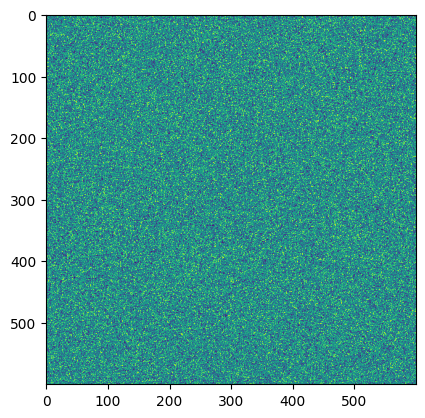

In [69]:
import matplotlib.pyplot as plt

plt.imshow(random_data_large[0,0,:])

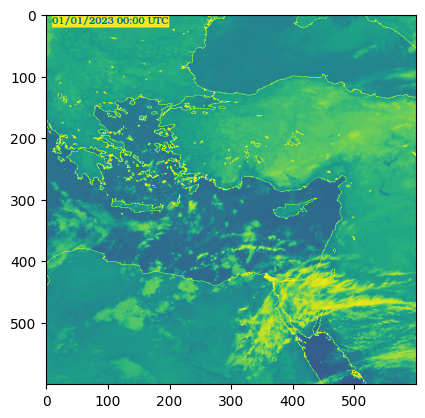

In [70]:

plt.imshow(real_img)